# TCN Model

In [1]:
#Imports
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from tcn import TCN, tcn_full_summary
from keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1)Loading Dataset

In [2]:
df=pd.read_csv("df_Original.csv")
df.head()

,tweet_id,label,text,length,preprocessed_abstract,length_after_cleaning,tokenized_text
0,570306133677760513,2,@VirginAmerica What @dhepburn said.,35,what say,8,"['what', 'say']"
1,570301130888122368,1,@VirginAmerica plus you've added commercials t...,72,plus add commercial experience tacky,36,"['plus', 'add', 'commercial', 'experience', 't..."
2,570301083672813571,2,@VirginAmerica I didn't today... Must mean I n...,71,i today must mean i need take another trip,42,"['i', 'today', 'must', 'mean', 'i', 'need', 't..."
3,570301031407624196,0,@VirginAmerica it's really aggressive to blast...,126,really aggressive blast obnoxious entertainmen...,78,"['really', 'aggressive', 'blast', 'obnoxious',..."
4,570300817074462722,0,@VirginAmerica and it's a really big bad thing...,55,really big bad thing,20,"['really', 'big', 'bad', 'thing']"


In [3]:
df.isnull().sum()

tweet_id                  0
label                     0
text                      0
length                    0
preprocessed_abstract    17
length_after_cleaning     0
tokenized_text            0
dtype: int64

In [4]:
df = df.dropna()

##### 2)Preparing Data

- Word2Vec model (pre-trained word embeddings) for embedding layer in the model

In [5]:
sentences = [sentence.split() for sentence in df['preprocessed_abstract']]
# Create and train the Word2Vec model
model_2= Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
# Access the word vectors
word_vectors = model_2.wv
word_vectors.vectors

array([[-3.72568876e-01,  4.46902394e-01,  3.62366252e-02, ...,
        -5.99462032e-01, -1.60616130e-01, -1.46761745e-01],
       [-8.95371258e-01,  7.28352010e-01,  1.00490585e-01, ...,
        -1.07304478e+00,  3.55727702e-01, -8.45657051e-01],
       [-2.36410841e-01,  5.54484010e-01, -8.91624689e-02, ...,
        -5.48562229e-01,  9.66106206e-02, -1.39762908e-01],
       ...,
       [ 5.94435353e-03,  9.22280177e-03, -1.09863526e-03, ...,
        -6.34492282e-03, -1.19147100e-03, -6.32755691e-03],
       [ 5.92717063e-03, -1.43440280e-04,  4.75345273e-03, ...,
        -9.86697804e-03,  7.31127150e-03, -7.56773446e-03],
       [-8.70730355e-03, -9.75005096e-04,  8.02892353e-03, ...,
        -1.53629556e-02, -4.53643413e-04, -1.07408930e-02]], dtype=float32)

In [6]:
word_vectors.vectors.shape

(9314, 100)

#####  3) Split , into Training and Validation Sets (80:20)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_abstract'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (11698,) (11698,)
Test data: (2925,) (2925,)


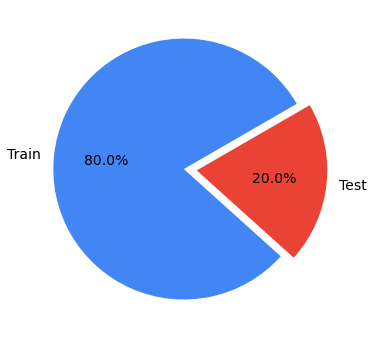

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(y_train), len(y_test)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0.05),
        startangle=30);

In [9]:
corp=X_train
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
max_length=max(len(d) for d in encoded_docs)
padded_docs_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_train)

[[ 218   38 1064 ...    0    0    0]
 [ 360  225   99 ...    0    0    0]
 [   2  334  599 ...    0    0    0]
 ...
 [  53  278   11 ...    0    0    0]
 [ 218 1150  251 ...    0    0    0]
 [  84  199    2 ...    0    0    0]]


In [10]:
corp=X_test
t = Tokenizer()
t.fit_on_texts(corp)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corp)
# print(encoded_docs)
padded_docs_test = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs_test)

[[524  14  13 ...   0   0   0]
 [  1   3  17 ...   0   0   0]
 [ 34  33   4 ...   0   0   0]
 ...
 [ 85 241  44 ...   0   0   0]
 [481   8 850 ...   0   0   0]
 [  1  16   7 ...   0   0   0]]


##### 4)Model Architecture

In [11]:
def tcn_model(kernel_size = 1, activation='relu', input_dim = None, 
                   output_dim=100, max_length = None, emb_matrix = None):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, 
                  output_dim=output_dim, 
                  input_length=max_length,
                  # Assign the embedding weight with word2vec embedding marix
                  weights = [emb_matrix],
                  # Set the weight to be not trainable (static)
                  trainable = False)(inp)
    
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(32,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.5)(conc)
    outp = Dense(3, activation="softmax")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

In [12]:
model =tcn_model(input_dim=word_vectors.vectors.shape[0], output_dim=100, max_length=max_length, emb_matrix=word_vectors.vectors)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 26)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 26, 100)              931400    ['input_1[0][0]']             
                                                                                                  
 spatial_dropout1d (Spatial  (None, 26, 100)              0         ['embedding[0][0]']           
 Dropout1D)                                                                                       
                                                                                                  
 tcn1 (TCN)                  (None, 26, 128)              297856    ['spatial_dropout1d[0][0]

##### 5) Training Model

In [13]:
history=model.fit(padded_docs_train, y_train, epochs=100, batch_size=100, validation_data=(padded_docs_test, y_test))
history

Epoch 1/100


117/117 [==============================] - 11s 57ms/step - loss: 1.0083 - accuracy: 0.6184 - val_loss: 0.8640 - val_accuracy: 0.6274
Epoch 2/100
117/117 [==============================] - 6s 51ms/step - loss: 0.9171 - accuracy: 0.6263 - val_loss: 0.8483 - val_accuracy: 0.6274
Epoch 3/100
117/117 [==============================] - 6s 54ms/step - loss: 0.8832 - accuracy: 0.6416 - val_loss: 0.8122 - val_accuracy: 0.6639
Epoch 4/100
117/117 [==============================] - 6s 52ms/step - loss: 0.8396 - accuracy: 0.6622 - val_loss: 0.8031 - val_accuracy: 0.6670
Epoch 5/100
117/117 [==============================] - 6s 51ms/step - loss: 0.8299 - accuracy: 0.6634 - val_loss: 0.8067 - val_accuracy: 0.6588
Epoch 6/100
117/117 [==============================] - 6s 51ms/step - loss: 0.8266 - accuracy: 0.6614 - val_loss: 0.8050 - val_accuracy: 0.6677
Epoch 7/100
117/117 [==============================] - 6s 51ms/step - loss: 0.8217 - accuracy: 0.6598 - val_loss: 0.8044 - val_accura

117/117 [==============================] - 6s 49ms/step - loss: 0.4819 - accuracy: 0.7867 - val_loss: 1.3177 - val_accuracy: 0.5897
Epoch 55/100
117/117 [==============================] - 6s 50ms/step - loss: 0.4540 - accuracy: 0.7971 - val_loss: 1.5486 - val_accuracy: 0.6260
Epoch 56/100
117/117 [==============================] - 6s 50ms/step - loss: 0.4665 - accuracy: 0.7940 - val_loss: 1.4883 - val_accuracy: 0.6024
Epoch 57/100
117/117 [==============================] - 6s 50ms/step - loss: 0.4416 - accuracy: 0.8067 - val_loss: 1.6130 - val_accuracy: 0.6164
Epoch 58/100
117/117 [==============================] - 6s 51ms/step - loss: 0.4438 - accuracy: 0.7990 - val_loss: 1.4737 - val_accuracy: 0.5556
Epoch 59/100
117/117 [==============================] - 6s 49ms/step - loss: 0.4429 - accuracy: 0.8063 - val_loss: 1.7339 - val_accuracy: 0.6188
Epoch 60/100
117/117 [==============================] - 6s 49ms/step - loss: 0.4177 - accuracy: 0.8161 - val_loss: 1.8326 - val_accuracy: 0.612

##### 6) Finding Training and Testing Accuracy

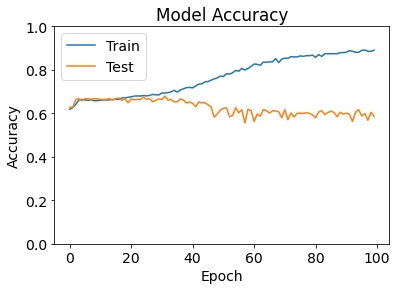

In [14]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
test_loss,test_acc=model.evaluate(padded_docs_test,y_test)
test_loss,test_acc

92/92 [==============================] - 1s 10ms/step - loss: 2.4811 - accuracy: 0.5856


(2.481083631515503, 0.5856410264968872)

##### 7) Compute and plot the confusion matrix for the three classes

In [18]:
predictions=model.predict(padded_docs_test)
class_labels = ['negative', 'positive','neutral']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[actual] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

92/92 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

    negative       0.71      0.71      0.71      1835
     neutral       0.33      0.42      0.37       617
    positive       0.49      0.32      0.39       473

    accuracy                           0.59      2925
   macro avg       0.51      0.48      0.49      2925
weighted avg       0.60      0.59      0.59      2925



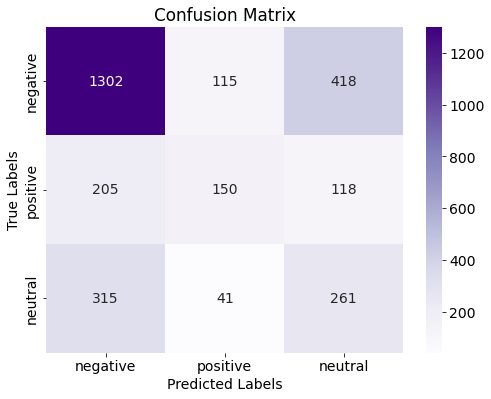

In [19]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 8) Saving the final results in Excel sheet

In [20]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.71459934 0.32747804 0.49019608]
Recall per class: [0.70953678 0.42301459 0.31712474]


In [21]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.5856410256410256
Macro F1 Score: 0.48877788901120844


In [22]:
data={'Original_Dataset':[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]}
result=pd.DataFrame(data,index=['Training Accuracy','Testing Accuracy','Micro F1 Score','Macro F1 Score','Precision for Negative sentiment','Precision for Positive sentiment','Precision for Neutral sentiment','Recall for Negative sentiment','Recall for Positive sentiment','Recall for Neutral sentiment'])
result

,Original_Dataset
Training Accuracy,0.891178
Testing Accuracy,0.585641
Micro F1 Score,0.585641
Macro F1 Score,0.488778
Precision for Negative sentiment,0.714599
Precision for Positive sentiment,0.327478
Precision for Neutral sentiment,0.490196
Recall for Negative sentiment,0.709537
Recall for Positive sentiment,0.423015
Recall for Neutral sentiment,0.317125


In [23]:
result.to_csv('TCNModelResults.csv', index=True)